In [77]:
import numpy as np
import pandas as pd
import datetime

from fuzzywuzzy import process, fuzz
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



In [78]:
# DATA SOURCE: http://web.mta.info/developers/turnstile.html
# FIELD DESCRIPTIONS: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt
# STATION ENTRANCES: http://web.mta.info/developers/data/nyct/subway/StationEntrances.csv

### Gather Data into DataFrame

In [79]:
# DON'T RUN IF YOU HAVE PKL FILE

# dates = ['160625.txt', '160618.txt', '160611.txt', '160604.txt', '160528.txt', 
#          '160521.txt', '160514.txt', '160507.txt']

# base_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'



# subway_df = pd.DataFrame()

# for date in dates:
#     print date
#     data = pd.read_csv(base_url + date, parse_dates=[[6,7]])
#     subway_df = pd.concat([df, data])

# subway_df.to_pickle('subway_df.pkl')

In [80]:
# Did all the dirty work and saved it as a pickle cuz way faster

df = pd.read_pickle('subway_df.pkl')

In [81]:
df.shape

(1553954, 10)

In [82]:
# Adjust Column Names and Drop Path/Staten Island Railrod 
# SRT LINENAME is 1 so it really messes me up

df.columns = [u'DATE_TIME', u'C_A', u'UNIT', u'SCP', u'STATION', u'LINENAME',
       u'DIVISION', u'DESC', u'ENTRIES', u'EXITS']

df.STATION = df.STATION.str.replace('/',' ')
df.drop(df[df.DIVISION =='PTH'].index, inplace = True)
df.drop(df[df.DIVISION =='SRT'].index, inplace = True)

In [83]:
df.shape

(1453116, 10)

In [84]:
def _fix_multi_lines(df):
    ''' Station Names in data are re-used across different staions that happen to be on the same 
    street in different parts of the city. For example, '96 ST' is used in the data to refer to
    96th st and broadway, 96th st cpw and 96th and lex.
    This function renames stations that are re-used by appending corresponding line_names to the
    end of the station_name eg 96 ST become 96 ST_123 & 96 ST_bc & 96 ST_6 '''
    multi_line = {}
    for stn in df.STATION.unique():
        if len(df[df.STATION == stn].LINENAME.unique())>1:
            multi_line[stn]=df[df.STATION == stn].LINENAME.unique()
    # These have multiple lines but are the same station
    same = ['14 ST-UNION SQ', '161 YANKEE STAD', '34 ST-PENN STA', '42 ST-PORT AUTH', 'TIMES SQ-42 ST', 
    '59 ST COLUMBUS', 'ATL AV-BARCLAY', 'BOROUGH HALL' ]
    for s in same:
        del(multi_line[s])

    for stn in multi_line.keys():
        if stn == 'FULTON ST':
            frame = df[df.STATION == stn]
            zipped = zip(frame.index, frame.STATION.values, frame.LINENAME.values)
            for x in range(len(zipped)):
                if zipped[x][2] != 'G':
                    zipped[x] = (zipped[x][0],zipped[x][1], 'acjz2345')
            indx = [z[0] for z in zipped]
            vals = [z[1] + '_' + z[2].lower() for z in zipped]
            combined = pd.Series(dict(zip(indx,vals)))
            df.loc[df.STATION == stn, 'STATION'] = combined
        else:
            frame = df[df.STATION == stn]
            zipped = zip(frame.index, frame.STATION.values, frame.LINENAME.values)
            indx = [z[0] for z in zipped]
            vals = [z[1] + '_' + z[2].lower() for z in zipped]
            combined = pd.Series(dict(zip(indx,vals)))
            df.loc[df.STATION == stn, 'STATION'] = combined
    return df


In [85]:
_fix_multi_lines(df);

### Adjust Data
    - check for Errors/Nulls
    - take diffs by turnstile

In [86]:
# TAKE DIFF OF ENTRIES AND EXITS

df.ENTRIES = df.groupby(['C_A', 'SCP']).ENTRIES.apply(lambda g: g.diff())
df.EXITS = df.groupby(['C_A', 'SCP']).EXITS.apply(lambda g: g.diff())
df.fillna(0, inplace=True)

df.head()

,DATE_TIME,C_A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
0,2016-06-18 00:00:00,A002,R051,02-00-00,59 ST_nqr456,NQR456,BMT,REGULAR,0.0,0.0
1,2016-06-18 04:00:00,A002,R051,02-00-00,59 ST_nqr456,NQR456,BMT,REGULAR,0.0,15.0
2,2016-06-18 08:00:00,A002,R051,02-00-00,59 ST_nqr456,NQR456,BMT,REGULAR,0.0,57.0
3,2016-06-18 12:00:00,A002,R051,02-00-00,59 ST_nqr456,NQR456,BMT,REGULAR,0.0,107.0
4,2016-06-18 16:00:00,A002,R051,02-00-00,59 ST_nqr456,NQR456,BMT,REGULAR,0.0,76.0


In [87]:
print len(df[df.ENTRIES>10000])
print len(df[df.EXITS>10000])

407
318


In [88]:
# ERRORS 

# Treating entries/exits <0 and greater than 100,000 as NULLs

df.loc[df.ENTRIES<0, 'ENTRIES'] = np.nan
df.loc[df.EXITS<0, 'EXITS'] = np.nan
df.loc[df.ENTRIES>10000, 'ENTRIES'] = np.nan
df.loc[df.EXITS>10000, 'EXITS'] = np.nan


test_df = df.groupby('STATION').transform(lambda g: g.fillna(g.median()))

df.ENTRIES = test_df.ENTRIES
df.EXITS = test_df.EXITS

In [89]:
# TEST

# bottom should be filled :-)
df[df.STATION == '57 ST-7 AV'][-50:]



,DATE_TIME,C_A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
1361131,2016-05-05 20:00:00,A011,R080,01-00-04,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0
1361132,2016-05-06 00:00:00,A011,R080,01-00-04,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0
1361133,2016-05-06 04:00:00,A011,R080,01-00-04,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0
1361134,2016-05-06 08:00:00,A011,R080,01-00-04,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0
1361135,2016-05-06 12:00:00,A011,R080,01-00-04,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0
1361136,2016-05-06 16:00:00,A011,R080,01-00-04,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0
1361137,2016-05-06 20:00:00,A011,R080,01-00-04,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0
1361138,2016-04-30 00:00:00,A011,R080,01-00-05,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0
1361139,2016-04-30 04:00:00,A011,R080,01-00-05,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0
1361140,2016-04-30 08:00:00,A011,R080,01-00-05,57 ST-7 AV,NQR,BMT,REGULAR,207.0,115.0


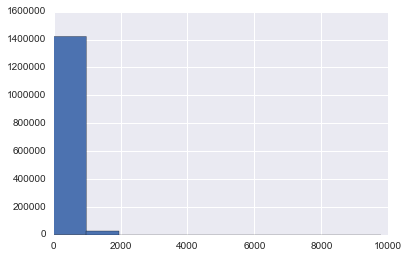

In [90]:
df.ENTRIES.hist()

END OF CLEANING

---------------------------------------------------------------------------------------------------

Compute Daily Totals for Each Station

In [91]:
days = pd.Grouper(key = 'DATE_TIME', freq='d')
stn_totals = df.groupby(['STATION', days]).sum().reset_index()

stn_totals.head(10)

,STATION,DATE_TIME,ENTRIES,EXITS
0,1 AV,2016-04-30,17849.0,16455.5
1,1 AV,2016-05-01,16776.0,15705.0
2,1 AV,2016-05-02,22390.0,19348.0
3,1 AV,2016-05-03,24699.0,20555.0
4,1 AV,2016-05-04,25374.0,21902.0
5,1 AV,2016-05-05,25179.0,21816.0
6,1 AV,2016-05-06,26572.0,22611.0
7,1 AV,2016-05-07,17330.0,16176.5
8,1 AV,2016-05-08,16153.0,14884.0
9,1 AV,2016-05-09,22045.0,20334.0


### Average Daily Traffic Per Station

Here we are just looking at how many peeople use each station on average.

We see high traffic exactly where we expect: 
    - Stations in midtown (Penn Station, Grand Central, Times Square)
    - Stations with lots of connections to other lines (Times Square, Union Sqr, Fulton, Columbus Circle)

                    ENTRIES   EXITS
STATION                            
34 ST-PENN STA       148840  125832
GRD CNTRL-42 ST      126977  113120
34 ST-HERALD SQ      105940   96180
14 ST-UNION SQ        95601   83293
42 ST-PORT AUTH       86789   63641
TIMES SQ-42 ST        86586   81033
FULTON ST_acjz2345    65706   54640
59 ST COLUMBUS        65486   51294
86 ST_456             57944   51629
FLUSHING-MAIN         54854   43548
47-50 STS ROCK        49045   51724
JKSN HT-ROOSVLT       46110   33864
59 ST_456nqr          43211   40070
CANAL ST_jnqrz6       40578   29114
ATL AV-BARCLAY        39258   35778


(array([      0.,   20000.,   40000.,   60000.,   80000.,  100000.,
         120000.,  140000.,  160000.]), <a list of 9 Text xticklabel objects>)

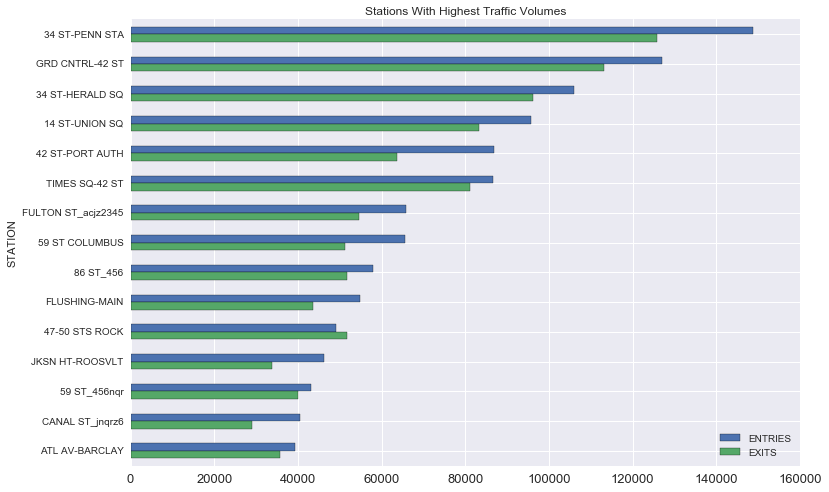

In [92]:
print stn_totals.groupby('STATION').mean().sort_values('ENTRIES', ascending = False).astype(int)[:15]



plt.figure(figsize=(12,8))
ax = plt.gca()
stn_totals.groupby('STATION').mean().sort_values('ENTRIES', ascending = False).astype(int)[:15].plot(kind = 'barh', ax = ax)
ax.invert_yaxis()
plt.title('Stations With Highest Traffic Volumes')
plt.xticks(size=13)

### Top 10 Stations By Day of the Week
    - The only trend is that there is significantly less traffic on Weekends
    - However the relationship between lines stays consistent throughout 
        • THE SAME STATIONS ARE THE BUSIEST EVERY DAY
        • While posting team members at these locations will ensure high traffic volume, be wary as these mostly 
          represent commuters hurrying to work!

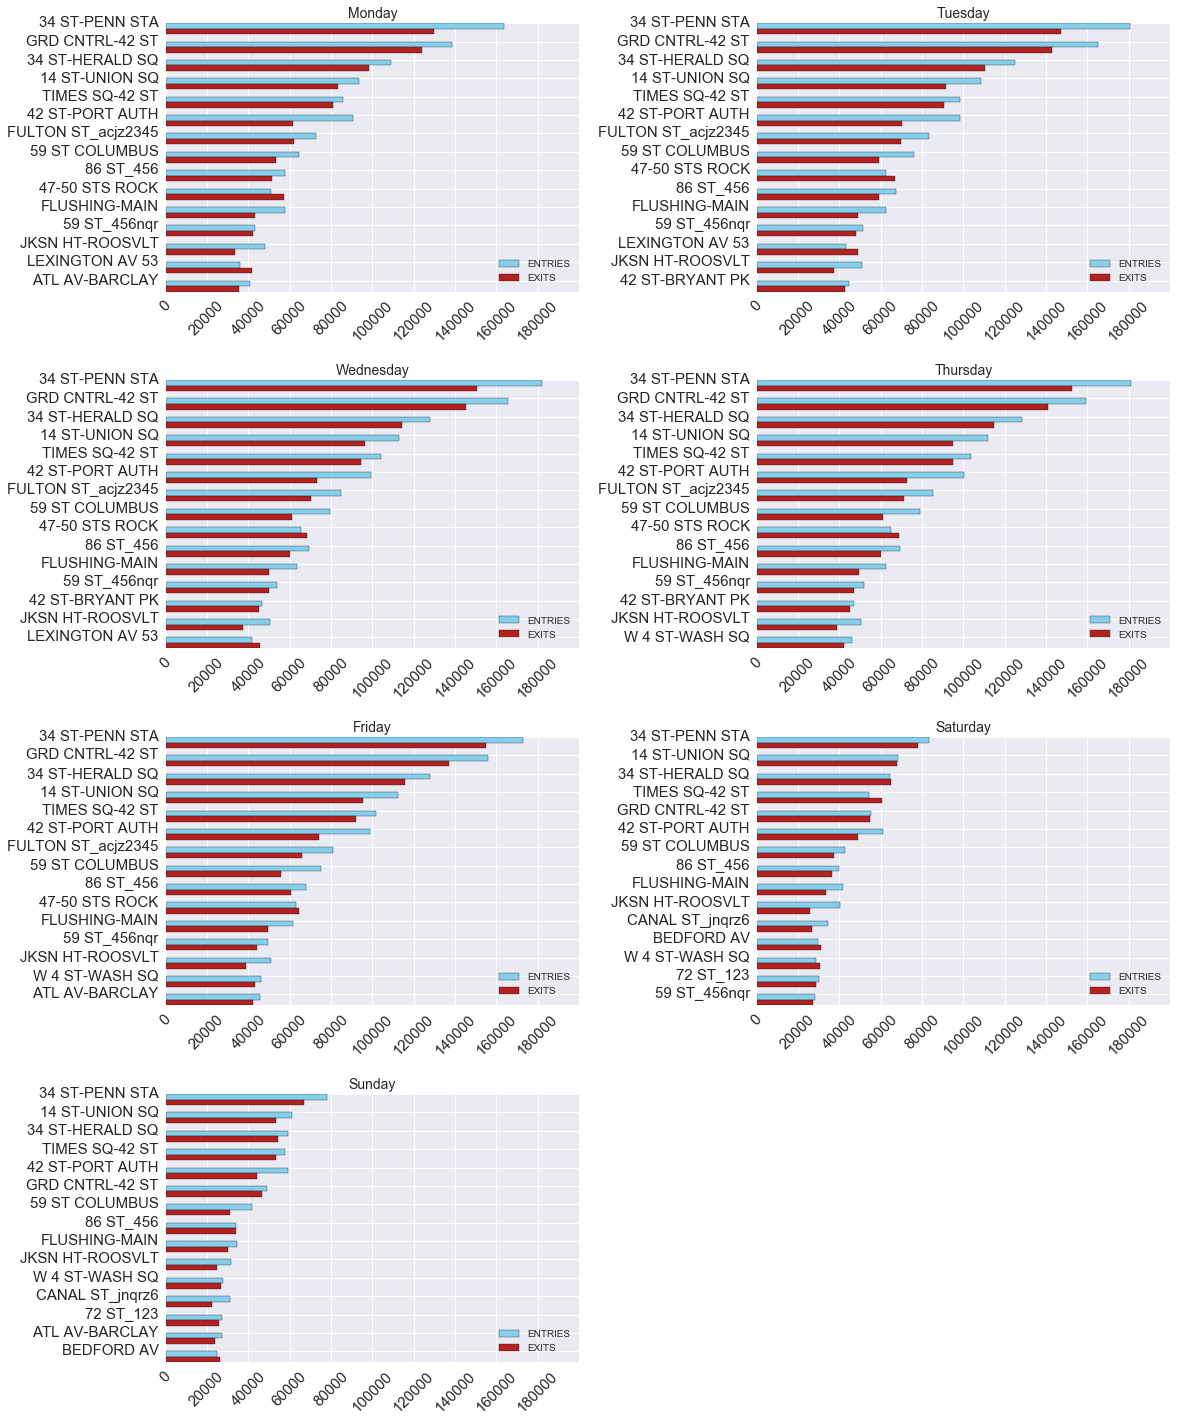

In [93]:
stn_totals['DOW'] = stn_totals.DATE_TIME.dt.dayofweek
weekly_means = stn_totals.groupby(['DOW','STATION']).mean().reset_index()
weekly_means['Total'] = weekly_means.ENTRIES + weekly_means.EXITS

plt.figure(figsize= (18,24))
height = 0.3
x1 = np.arange(15)-0.3
x2 = np.arange(15)

week_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for d in range(7):
    ax = plt.subplot(4,2,d+1)
    day = weekly_means[weekly_means.DOW ==d].sort_values('Total', ascending = False)[:15]
    y1 = day.ENTRIES
    y2 = day.EXITS
    yticklabels = day.STATION
    plt.barh(x1,y1, height = height, tick_label = yticklabels, label = 'ENTRIES', color = 'skyblue')
    plt.barh(x2,y2, height = height, label = 'EXITS', color = 'Firebrick')
    plt.title(week_names[d], size = 14)
    plt.xlim(0,200000)
    plt.yticks(size = 15)
    plt.xticks(range(0,200000,20000), rotation = 45,size=15)
    plt.gca().invert_yaxis()
    plt.legend(loc = 'lower right')
plt.subplots_adjust(wspace = 0.43, hspace = 0.33)





### Looking at Busiest Stations by Hour of the Day

We are going to look at each day in 6 hour blocks representing morning through nighttime.
This should help us capture traffic differences between peak vs non-peak hours

In [94]:
# CREATE 6-HOUR TIME BLOCKS

bins = [0,4,8,12,16,20,24]
labels = ['Midnight','Early_Morning','Morning_Rush','Midday','Eve_Rush','Eve']
df['TOD'] = pd.cut(df.DATE_TIME.dt.hour,bins, labels = labels, right=False )


# SEPARATE INTO WEEKENDS AND WEEKDAYS

weekdays = df[df.DATE_TIME.dt.dayofweek <5]
weekends = df[df.DATE_TIME.dt.dayofweek >4]

# weekdays
wkdy_stn_tod_totals = weekdays.groupby(['STATION',days, 'TOD']).sum().reset_index()
wkdy_stn_tod_means = wkdy_stn_tod_totals.groupby(['STATION','TOD']).mean().reset_index()
wkdy_stn_tod_means['Total'] = wkdy_stn_tod_means.ENTRIES + wkdy_stn_tod_means.EXITS

#weekends
wknd_stn_tod_totals = weekends.groupby(['STATION',days, 'TOD']).sum().reset_index()
wknd_stn_tod_means = wknd_stn_tod_totals.groupby(['STATION','TOD']).mean().reset_index()
wknd_stn_tod_means['Total'] = wknd_stn_tod_means.ENTRIES + wknd_stn_tod_means.EXITS

print 'WEEKDAYS: \n'
print wkdy_stn_tod_means.head(10)
print '\n'
print 'WEEKENDS: \n'
print wknd_stn_tod_means.head(10)

WEEKDAYS: 

         STATION            TOD      ENTRIES        EXITS         Total
0           1 AV  Early_Morning   932.575000   822.075000   1754.650000
1           1 AV            Eve  7281.153846  5964.435897  13245.589744
2           1 AV       Eve_Rush  5021.750000  4029.750000   9051.500000
3           1 AV         Midday  5183.100000  5014.725000  10197.825000
4           1 AV       Midnight  3839.225000  3287.387500   7126.612500
5           1 AV   Morning_Rush  1956.325000  3296.425000   5252.750000
6  103 ST-CORONA  Early_Morning   411.950000  1026.125000   1438.075000
7  103 ST-CORONA            Eve  2923.575000  5619.950000   8543.525000
8  103 ST-CORONA       Eve_Rush  3220.846154  2686.333333   5907.179487
9  103 ST-CORONA         Midday  5315.900000  1356.100000   6672.000000


WEEKENDS: 

         STATION            TOD    ENTRIES       EXITS       Total
0           1 AV  Early_Morning  1795.5000  1334.18750  3129.68750
1           1 AV            Eve  4613.5625  4822

Here we see some more variation. While the majority of "heavy duty" stations are still here, they are not allways in the same order. Some stations are better for different times of day than others. Additionaly we see some "smaller" stations make the cut here and there as well.
    - 5th Ave 53rd St
    - W 4th st
    - Bedford Ave
    - Kew Gardens
    - 96th st and 72nd st and broadway

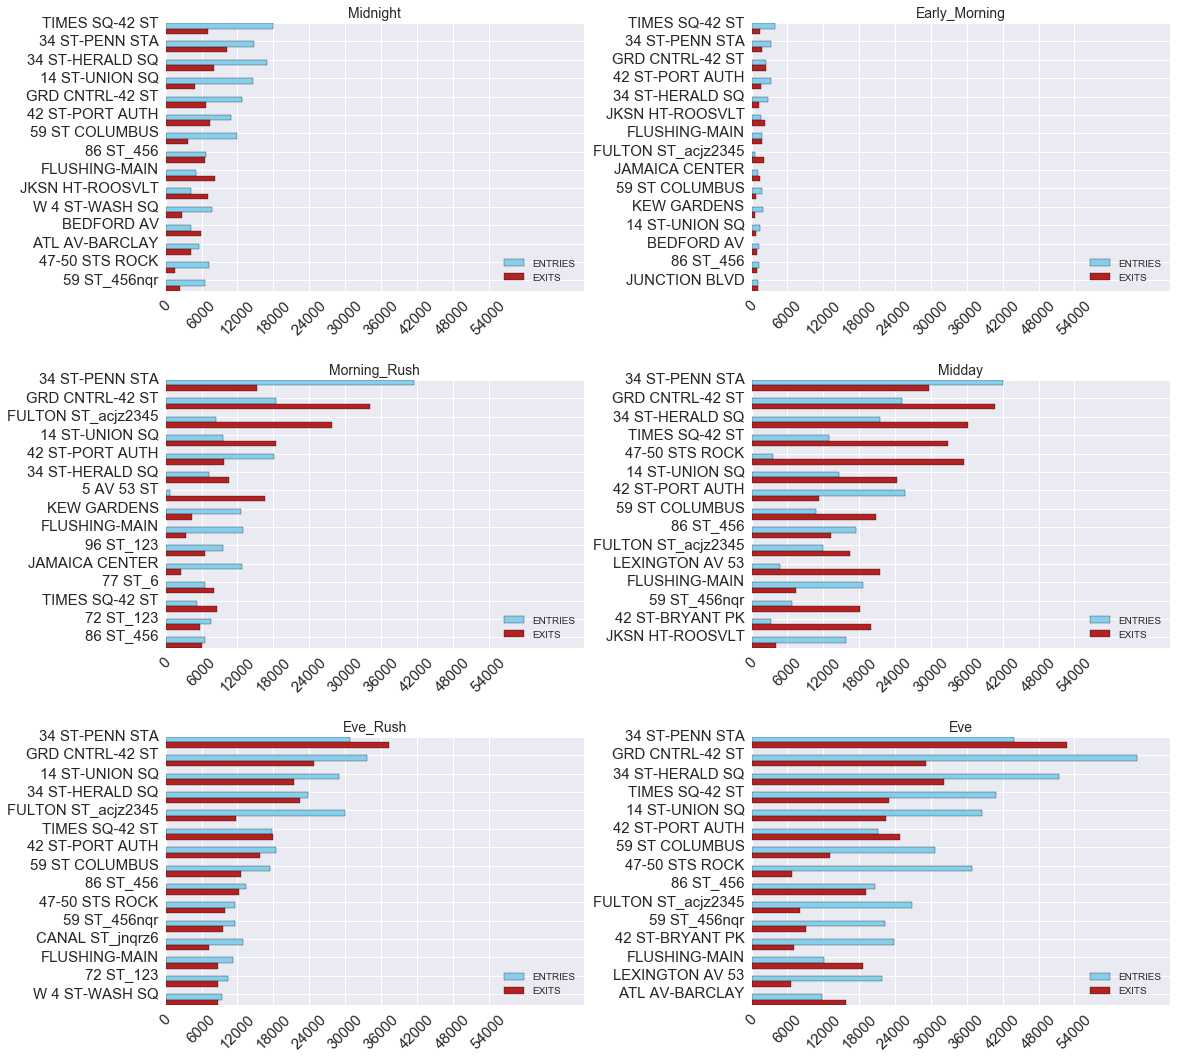

In [95]:
# WEEKDAYS
plt.figure(figsize= (18,24))
height = 0.3
x1 = np.arange(15)-0.3
x2 = np.arange(15)

for l in range(len(labels)):
    ax = plt.subplot(4,2,l+1)
    time = wkdy_stn_tod_means[wkdy_stn_tod_means.TOD ==labels[l]].sort_values('Total', ascending = False)[:15]
    y1 = time.ENTRIES
    y2 = time.EXITS
    yticklabels = time.STATION
    plt.barh(x1,y1, height = height, tick_label = yticklabels, label = 'ENTRIES', color = 'skyblue')
    plt.barh(x2,y2, height = height, label = 'EXITS', color = 'Firebrick')
    plt.title(labels[l], size = 14)
    plt.xlim(0,70000)
    plt.yticks(size = 15)
    plt.xticks(range(0,60000,6000), rotation = 45,size=15)
    plt.gca().invert_yaxis()
    plt.legend(loc = 'lower right')
    
plt.subplots_adjust(hspace=0.33, wspace = 0.4)

Two stations not to discount are 47-50th ST Rock Center and 53rd ST Lexington Ave. These two stations made it into the top 15 of stations during midday. Additionally, the majority of their traffic are exits. These are people coming to shop and to spend their free time exploring. They are open to new ideas and are perfect candidates for our Gala!

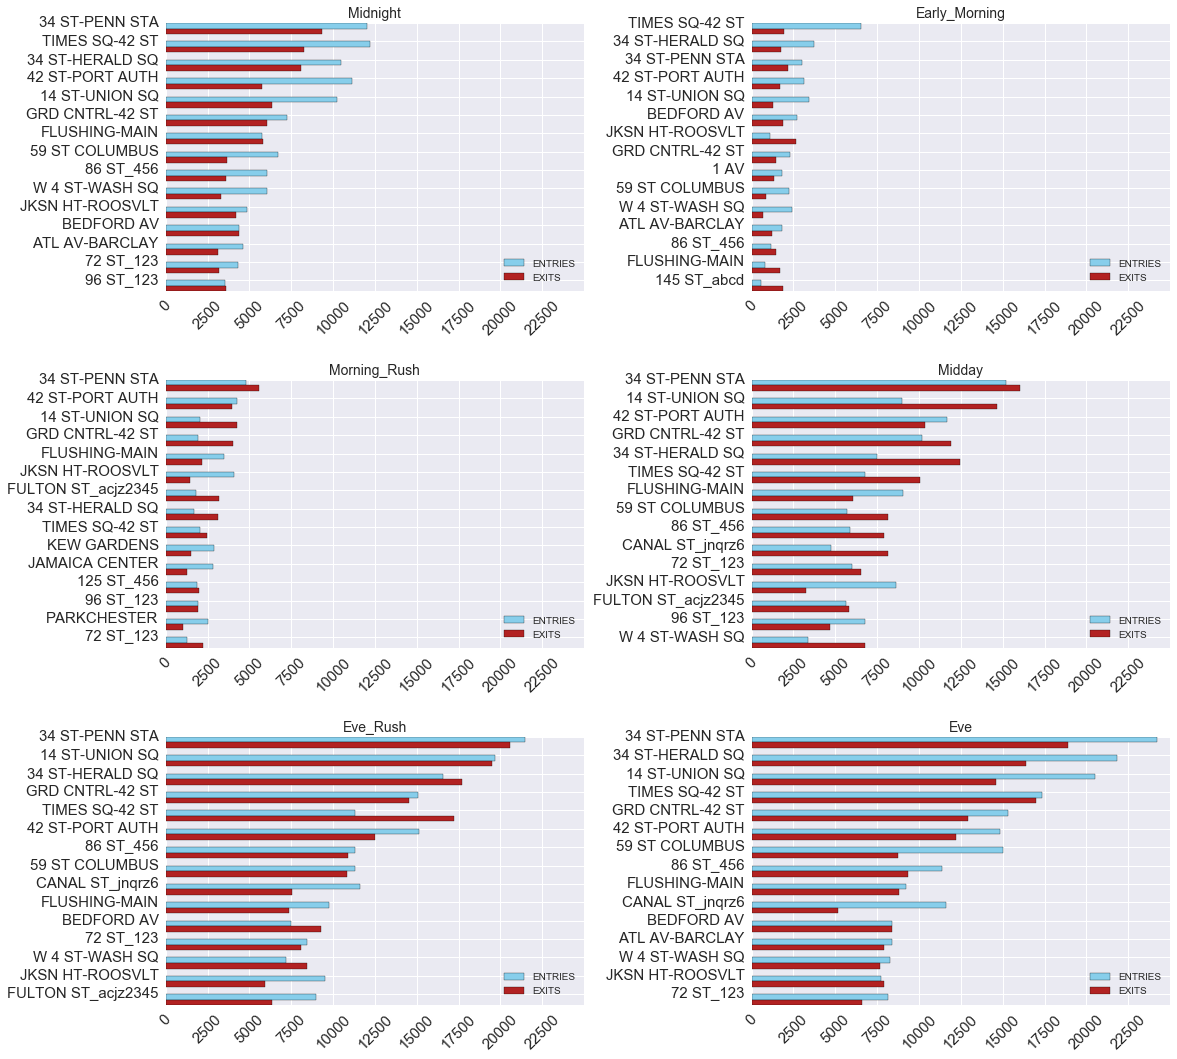

In [96]:
# WEEKENDS
plt.figure(figsize= (18,24))
height = 0.3
x1 = np.arange(15)-0.3
x2 = np.arange(15)

for l in range(len(labels)):
    ax = plt.subplot(4,2,l+1)
    time = wknd_stn_tod_means[wknd_stn_tod_means.TOD ==labels[l]].sort_values('Total', ascending = False)[:15]
    y1 = time.ENTRIES
    y2 = time.EXITS
    yticklabels = time.STATION
    plt.barh(x1,y1, height = height, tick_label = yticklabels, label = 'ENTRIES', color = 'skyblue')
    plt.barh(x2,y2, height = height, label = 'EXITS', color = 'Firebrick')
    plt.title(labels[l], size = 14)
    plt.xlim(0,25000)
    plt.yticks(size = 15)
    plt.xticks(range(0,25000,2500), rotation = 45,size=15)
    plt.gca().invert_yaxis()
    plt.legend(loc = 'lower right')
    
plt.subplots_adjust(hspace=0.33, wspace = 0.4)

The main lesson here is that people sleep in on weekends! The "morning rush" time is more like the "morning after" time!

Takeaways:
    - Place people at Bedford Ave and Barclays during the evening! Catch all the hipsters as they are going to bars to drink obscure ipas and tell them how avante garde and progressive our event is!
    - West 4th St and Canal Street are bustling on the weekends. People Shopping, drinking, partying. Those are the hotspots for weekend life!

### Investigating Top 15 Stations

Now that we've seen that the busiest stations are consistent throught a week, we'll investigate them in more detail.

    - What does their traffic look like over time
    - What are their busiest days/times
    - How does rush hour differ from midday
    


In [21]:
# Here are our busiest stations

top_stations = weekly_means[weekly_means.DOW ==1].sort_values('Total', ascending = False).STATION[:15]
top_stations

531        34 ST-PENN STA
739       GRD CNTRL-42 ST
529       34 ST-HERALD SQ
466        14 ST-UNION SQ
858        TIMES SQ-42 ST
539       42 ST-PORT AUTH
730    FULTON ST_acjz2345
558        59 ST COLUMBUS
543        47-50 STS ROCK
591             86 ST_456
717         FLUSHING-MAIN
559          59 ST_456nqr
778       LEXINGTON AV 53
764       JKSN HT-ROOSVLT
538       42 ST-BRYANT PK
Name: STATION, dtype: object

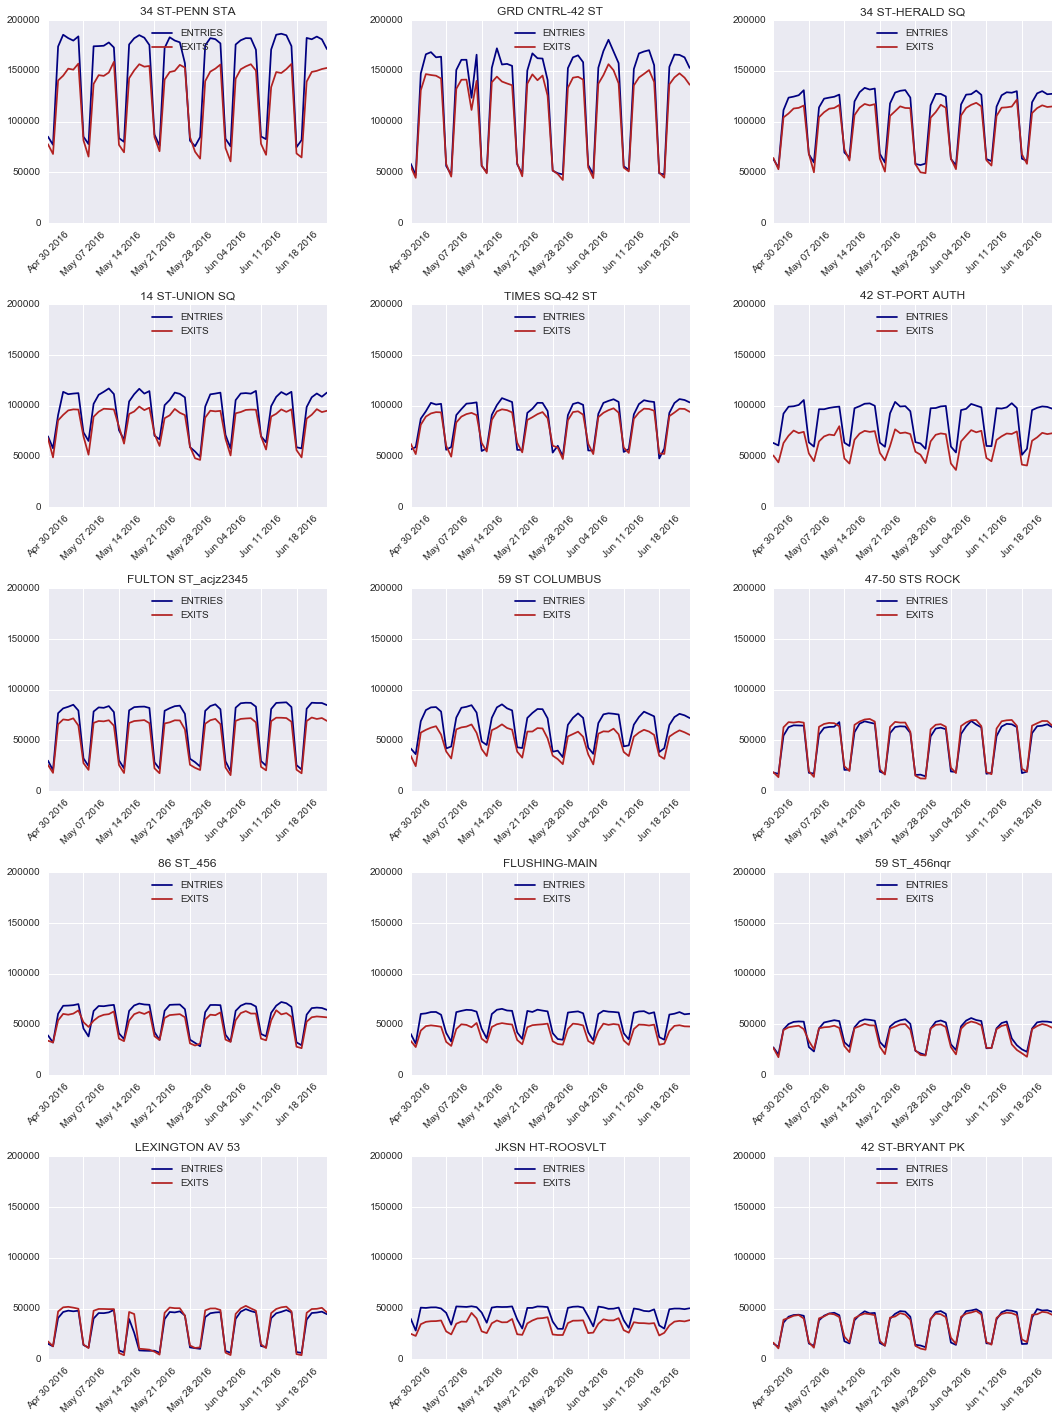

In [22]:
plt.figure(figsize = (18,24))
n = 1
for s in top_stations.values:
    stn = stn_totals[stn_totals.STATION == s]
    plt.subplot(5,3, n)
    plt.plot(stn.DATE_TIME.dt.date, stn.ENTRIES, label ='ENTRIES', color = 'navy')
    plt.plot(stn.DATE_TIME.dt.date, stn.EXITS, label ='EXITS', color = 'firebrick')
    plt.title(s)
    plt.xticks(rotation = 45)
    plt.ylim(0,200000)
    plt.legend(loc = 'upper center')
    n+=1

plt.subplots_adjust(hspace = 0.4, wspace = 0.3)

Takeaways:
    - HAVE SOMEONE AT PENN STATION AND GRD CENTRAL AT ALL TIMES
    - Certain Stations show a greater difference between entrances and exits. 
        • my personal theory is that a station with greater exits is better than one with greater entrances.
            People getting on the train have further to go and are in more of a rush.

--------------------------------------------------------

### Busiest Days 


In [23]:
busiest_days = {}
for s in top_stations:
    stn = stn_totals[stn_totals.STATION==s]
    stn['Total'] = stn.ENTRIES + stn.EXITS
    mx = stn.groupby('DOW').mean().sort_values('Total', ascending = False).iloc[0]
    print s, ':', week_names[mx.name], '\n'
    print mx, '\n', '------------------------------\n'

/Users/RickS/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


34 ST-PENN STA : Thursday 

ENTRIES    180936.625
EXITS      152649.500
Total      333586.125
Name: 3, dtype: float64 
------------------------------

GRD CNTRL-42 ST : Wednesday 

ENTRIES    165778.250
EXITS      145155.875
Total      310934.125
Name: 2, dtype: float64 
------------------------------

34 ST-HERALD SQ : Friday 

ENTRIES    127703.875
EXITS      115898.500
Total      243602.375
Name: 4, dtype: float64 
------------------------------

14 ST-UNION SQ : Wednesday 

ENTRIES    112847.50
EXITS       96395.25
Total      209242.75
Name: 2, dtype: float64 
------------------------------

TIMES SQ-42 ST : Thursday 

ENTRIES    103793.375
EXITS       95056.000
Total      198849.375
Name: 3, dtype: float64 
------------------------------

42 ST-PORT AUTH : Friday 

ENTRIES     98881.250
EXITS       74351.625
Total      173232.875
Name: 4, dtype: float64 
------------------------------

FULTON ST_acjz2345 : Thursday 

ENTRIES     85413.0
EXITS       71031.0
Total      156444.0
Name

Takeaways:
    - Maximize exposure by placing team members at locations on their best day!
        • Fulton ST is busiest on Thursday!
        • Columbus circle is busiest on Wednesday!
        • Lexington Ave 53rd ST is busiest on Tuesday!

While the difference is subtle, scaling the data reveals that weds and thursdays are markedly busier than the rest of the week, while monday is suprisingly light.

([<matplotlib.axis.XTick at 0x1264aaf50>,
 <a list of 7 Text xticklabel objects>)

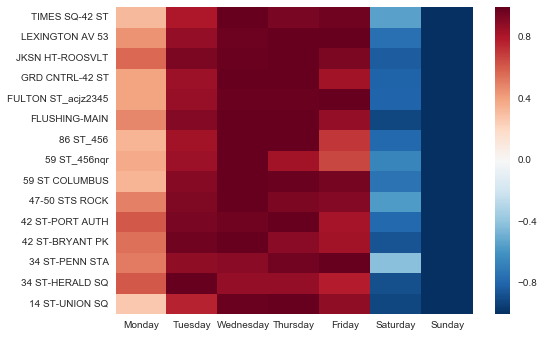

In [72]:
top15 = stn_totals[stn_totals.STATION.isin(top_stations)]

from sklearn.preprocessing import StandardScaler, MinMaxScaler

d = top15.pivot_table('ENTRIES','DOW','STATION')+top15.pivot_table('EXITS','DOW','STATION')
sc = StandardScaler().fit_transform(d)
mm = MinMaxScaler(feature_range=(-1,1)).fit_transform(d)
sns.heatmap(mm.T)
plt.yticks(np.arange(15)+0.5, d.columns, rotation = 0)
plt.xticks(np.arange(7)+0.5, week_names)
